# CNNs  using Transfer Learning

## 1. IMPORTING LIBRARIES

In [ ]:
import cv2
from skimage.filters import threshold_multiotsu
import albumentations as A

import numpy as np
from matplotlib import pyplot as plt
import os
import random
from datetime import datetime 
import csv

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten ,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import load_model

## 2. FUNCTION FOR OHE AND GET DETAILS OF THE DATA

In [ ]:
#Function for One Hot Encoding

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

#Function to get details of data

def load_data(train_dir , test_dir):
    
    print('Function load data has been called....')
    print('The following function outputs a dictionary with key-value pairs as : \n')
    print("""output = {  'x_train_path'    : x_train_path,
            'x_test_path'     : x_test_path,
            'classes'         : classes,
            'class_number'    : class_number,
            'class_imbalance' : class_imbalance }""")
    print('\nUse the appropriate keys to access data\n\n')
    
    #Getting path to the files
    x_train_path = [train_dir +'/'+ i +'/' + j for i in os.listdir(train_dir) for j in os.listdir(train_dir+'/'+i) ]
    x_test_path  = [test_dir +'/'+ i for i in os.listdir(test_dir)]

    # Getting the class names and no. of images belonging to each class
    classes={}
    for i in os.listdir(train_dir):
        j = os.listdir(train_dir+'/'+i)
        classes[i]=len(j)
    print('*****************************************************************')
    print('No. of classes = ',len(classes) ,'\n')
    print('The given data has following classes with no. of images as given :\n\n',classes, '\n')
    

    #Assigning class_numbers to each class
    class_number = {}
    class_num = 0
    for i in os.listdir(train_dir):
        class_number[i] =  class_num
        class_num+=1
    print('*****************************************************************')
    print('The integers have been assigned to each class as given : \n\n',class_number,'\n')
    
    aug = str(input('Do you want minimum number of augmentations for balancing classes data? (y/n)'))
    if aug == 'y':
        class_imbalance={}
        for i in classes:
            class_imbalance[i]=max(classes.values())-classes[i]
        print('*****************************************************************')
        print('The class {} has maximum amt of data that is : {} '.format(max(classes,key=classes.get),max(classes.values())),'\n')
        print('Add given minimum num of images to balance the data : \n\n',class_imbalance)
    else:
        class_imbalance={}
        aug_num = int(input('How many augmentations do you want? Enter an integer'))
        for i in classes:
            class_imbalance[i]=aug_num-classes[i]
        print('\n*****************************************************************')
        print('Add given num of images to balance the data : \n\n',class_imbalance)

    output = {'x_train_path'    : x_train_path,
              'x_test_path'     : x_test_path,
              'classes'         : classes,
              'class_number'    : class_number,
              'class_imbalance' : class_imbalance}
    
    return output

In [ ]:
train_dir = 'E:/Q/plant-seedlings-classification/train'
test_dir = 'E:/Q/plant-seedlings-classification/test'
output = load_data(train_dir,test_dir)

Function load data has been called....
The following function outputs a dictionary with key-value pairs as : 

output = {  'x_train_path'    : x_train_path,
            'x_test_path'     : x_test_path,
            'classes'         : classes,
            'class_number'    : class_number,
            'class_imbalance' : class_imbalance }

Use the appropriate keys to access data


*****************************************************************
No. of classes =  12 

The given data has following classes with no. of images as given :

 {'Black-grass': 263, 'Charlock': 390, 'Cleavers': 287, 'Common Chickweed': 611, 'Common wheat': 221, 'Fat Hen': 475, 'Loose Silky-bent': 654, 'Maize': 221, 'Scentless Mayweed': 516, 'Shepherds Purse': 231, 'Small-flowered Cranesbill': 496, 'Sugar beet': 385} 

*****************************************************************
The integers have been assigned to each class as given : 

 {'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, '

## 3. PRE-PROCESSING THE DATA

#### The reason for choosing the below pre-processing steps is at the end

In [ ]:
def img_preprocess(data_path,data_array):
    
    for i in range(len(data_path)):
    
            #reading the image
            img = cv2.imread(data_path[i],1)
            
            #cvt bgr to lab
            lab_img = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)

            #splitting channels to take channel a
            l,a,b = cv2.split(lab_img)

            #Checking which blurring technique is better
            gauss_img = cv2.GaussianBlur(a,(3,3),0,borderType = cv2.BORDER_CONSTANT)
            median_img = cv2.medianBlur(a,5)

            #Generating a mask to eliminate background
            thresh = threshold_multiotsu(gauss_img,classes=2)
            thresh_img = np.digitize(gauss_img, bins=thresh)*-1 + 1

            #eliminating background using binary mask
            img[:,:,0] = img[:,:,0]*thresh_img
            img[:,:,1] = img[:,:,1]*thresh_img
            img[:,:,2] = img[:,:,2]*thresh_img
            
            img = cv2.resize(img,(256,256))
            data_array[i]=img

    return data_array

####################################################################################


def data_preparation(output_dict_frm_load_data):
    
    x_train_path    = output_dict_frm_load_data['x_train_path']
    x_test_path     = output_dict_frm_load_data['x_test_path']
    classes         = output_dict_frm_load_data['classes']
    class_number    = output_dict_frm_load_data['class_number']
    class_imbalance = output_dict_frm_load_data['class_imbalance']
    
    #creating arrays for storing input data
    X_train = np.zeros((len(x_train_path),256,256,3),dtype=np.uint8)
    X_test  = np.zeros((len(x_test_path),256,256,3) ,dtype=np.uint8)
    
    #Getting labels for the data
    Y_train = [class_number[i] for i in os.listdir(train_dir) for j in os.listdir(train_dir+'/'+i)]
    Y_train = one_hot(np.array(Y_train))
    
    X_train = img_preprocess(x_train_path,X_train)
    X_test  = img_preprocess(x_test_path,X_test)
    
    #Shuffling the data
    indexes = np.arange(len(X_train))
    np.random.shuffle(indexes)

    X_train = X_train[indexes]
    Y_train = Y_train.T[indexes]
    np.save('X_test',X_test)
    np.save('X_train',X_train)
    np.save('Y_train',Y_train)
    
    return X_train , X_test , Y_train

In [ ]:
X_train , X_test , Y_train = data_preparation(output)
print('X-train shape = {} \nX-test shape = {} \nY-train shape = {} '.format(X_train.shape,X_test.shape,Y_train.shape))

X-train shape = (4750, 256, 256, 3) 
X-test shape = (794, 256, 256, 3) 
Y-train shape = (4750, 12) 


## 4. AUGMENTATION TO BALANCE DATA

In [ ]:
#Augmenting data
def augmented_images(in_class , output_from_load_data):
    
    num_aug = output['class_imbalance'][in_class]

    class_paths = [path for path in output['x_train_path'] if path.split('/')[-2] == in_class]
    
    x_array = np.zeros((num_aug,256,256,3),dtype=np.uint8)
    
    y_array = [output_from_load_data['class_number'][in_class] for i in range(len(x_array))]
    
    c=0
    
    #Defining transforms to use
    transform =.C Aompose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(),
    A.ShiftScaleRotate(p=0.5)
    ])
    
    #Loop for the number of augmentations
    for i in range(num_aug):
        
        #Sample randomly from the class data
        random_sample_num = random.sample(range(output['classes'][in_class]),1)
        img = cv2.imread(class_paths[random_sample_num[0]])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(256,256))
        transformed = transform(image=img)
        transformed_image = transformed["image"]
        
        #cvt bgr to lab
        lab_img = cv2.cvtColor(transformed_image,cv2.COLOR_RGB2LAB)

        #splitting channels to take channel a
        l,a,b = cv2.split(lab_img)

        #Checking which blurring technique is better
        gauss_img = cv2.GaussianBlur(a,(3,3),0,borderType = cv2.BORDER_CONSTANT)
        median_img = cv2.medianBlur(a,5)

        #Generating a mask to eliminate background
        thresh = threshold_multiotsu(gauss_img,classes=2)
        thresh_img = np.digitize(gauss_img, bins=thresh)*-1 + 1

        #eliminating background using binary mask
        transformed_image[:,:,0] = transformed_image[:,:,0]*thresh_img
        transformed_image[:,:,1] = transformed_image[:,:,1]*thresh_img
        transformed_image[:,:,2] = transformed_image[:,:,2]*thresh_img
            
        x_array[c]=transformed_image
        c=c+1
        
    return x_array,y_array

####################################################################

#Add the augmented data to the original data

def add_aug_data(X_train,Y_train,output):
        
        temp=[]
        keys = list(output['classes'].keys())
        x_train = X_train
        
        for i in keys:
            if output['class_imbalance'][i] > 0: 
                x,y = augmented_images(i , output )
                x_train=np.append(x_train,x,axis=0)
                temp+=y
        y = one_hot(np.array(temp))
        y_train = np.append(Y_train,y.T,axis=0)
        print(x_train.shape , y_train.shape)
        
        #Shuffling the data
        indexes = np.arange(len(x_train))
        np.random.shuffle(indexes)

        x_train = x_train[indexes]
        y_train = y_train[indexes]
        
        np.save('X_train_aug',x_train)
        np.save('Y_train_aug',y_train)
        
        return x_train , y_train   

In [ ]:
X_train_aug , Y_train_aug = add_aug_data(X_train,Y_train,output)
print('augmented X-train shape = {} \naugmented Y-train shape = {} '.format(X_train_aug.shape,Y_train_aug.shape))

(12000, 256, 256, 3) (12000, 12)
augmented X-train shape = (12000, 256, 256, 3) 
augmented Y-train shape = (12000, 12) 


## 5. LOADING THE SAVED NUMPY ARRAYS FROM DISK

In [ ]:
# X_train=np.load('E:/Q/Numpy arrays/X_train.npy')
# Y_train=np.load('E:/Q/Numpy arrays/Y_train.npy')
# X_test=np.load('E:/Q/Numpy arrays/X_test.npy')

X_train_aug=np.load('E:/Q/Numpy arrays/X_train_aug.npy')
Y_train_aug=np.load('E:/Q/Numpy arrays/Y_train_aug.npy')
print(X_train_aug.shape , Y_train_aug.shape)

(12000, 256, 256, 3) (12000, 12)


## 6. MODELS

##### model refers to VGG16
##### model_2 refers to ResNet50
##### model_3 refers to InceptionV3

##### For each model multiple hyper parameters were checked ( BatchSize , kernel-initializer , Learning rates ,Dropout , No of units in Dense
##### layer,epochs)

##### Couldn't experiment with keras tuner , ReduceLRonPlateau , Early Stopping , Model checkpoints due to hardware and time constraints

### 6.1  VGG16

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

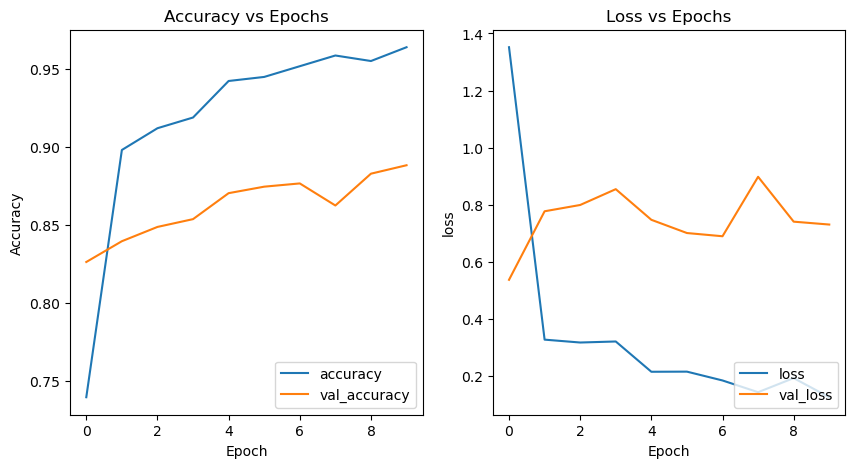

In [ ]:
# Define the number of classes
num_classes = 12

# Load the pre-trained VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze all the layers in the base model
for layer in vgg_model.layers:
    layer.trainable = False

# Add new classification layers on top of the frozen layers
x = Flatten()(vgg_model.output)
x = Dense(1024, activation='relu',kernel_initializer = 'glorot_uniform')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the new model
model = Model(inputs=vgg_model.input, outputs=predictions)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Print the model summary
model.summary()

start3 = datetime.now() 
results = model.fit(X_train_aug,Y_train_aug , batch_size=8,validation_split=0.2, epochs=10,shuffle=True)
stop3 = datetime.now()
execution_time = stop3-start3
print("\nVGG execution time is: ", execution_time)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Accuracy vs Epochs')
plt.plot(results.history['accuracy'], label='accuracy')
plt.plot(results.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.title('Loss vs Epochs')
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

plt.show()

In [ ]:
model.save('E:/Q/Trained_models/With augmentation/VGG16-aug-5epochs.hdf5')

### 6.2 ResNet50

Epoch 1/10
1200/1200 [==============================] - 76s 49ms/step - loss: 0.8812 - accuracy: 0.7283 - val_loss: 0.4481 - val_accuracy: 0.8450
Epoch 2/10
1200/1200 [==============================] - 50s 42ms/step - loss: 0.3727 - accuracy: 0.8674 - val_loss: 0.3813 - val_accuracy: 0.8629
Epoch 3/10
1200/1200 [==============================] - 50s 42ms/step - loss: 0.2946 - accuracy: 0.8963 - val_loss: 0.5114 - val_accuracy: 0.8571
Epoch 4/10
1200/1200 [==============================] - 51s 42ms/step - loss: 0.2395 - accuracy: 0.9140 - val_loss: 0.3600 - val_accuracy: 0.8838
Epoch 5/10
1200/1200 [==============================] - 50s 42ms/step - loss: 0.2084 - accuracy: 0.9262 - val_loss: 0.3858 - val_accuracy: 0.8933
Epoch 6/10
1200/1200 [==============================] - 50s 42ms/step - loss: 0.1697 - accuracy: 0.9406 - val_loss: 0.3460 - val_accuracy: 0.8929
Epoch 7/10
1200/1200 [==============================] - 50s 42ms/step - loss: 0.1703 - accuracy: 0.9392 - val_loss: 0.3904 -

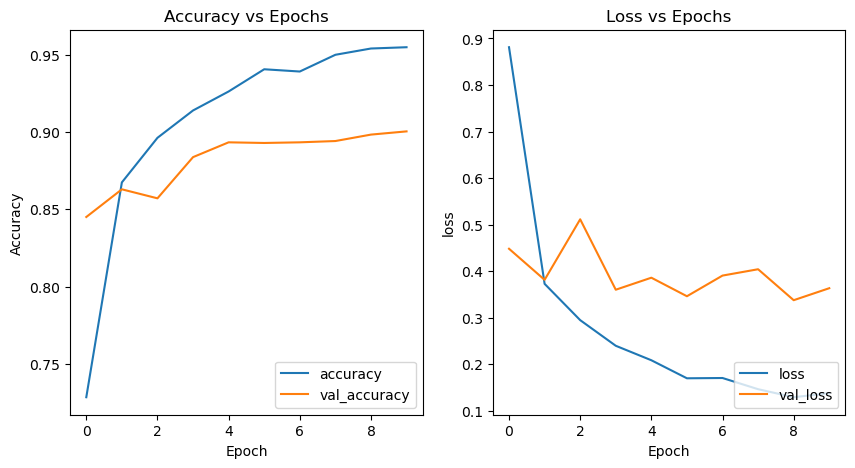

In [ ]:

# Define the number of classes
num_classes = 12

# Load the pre-trained VGG16 model
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze all the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Add new classification layers on top of the frozen layers
x = Flatten()(resnet50_model.output)
x = Dense(256, activation='relu',kernel_initializer = 'glorot_uniform')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the new model
model_2 = Model(inputs=resnet50_model.input, outputs=predictions)

# Compile the model
model_2.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Print the model summary
# model_2.summary()

start3 = datetime.now() 
results = model_2.fit(X_train_aug,Y_train_aug , batch_size=8,validation_split=0.2, epochs=10,shuffle=True)
stop3 = datetime.now()
execution_time = stop3-start3
print("\nResnet50 execution time is: ", execution_time)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Accuracy vs Epochs')
plt.plot(results.history['accuracy'], label='accuracy')
plt.plot(results.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2,)
plt.title('Loss vs Epochs')
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

plt.show()

In [ ]:
model_2.save('E:/Q/Trained_models/With augmentation/Resnet50-aug-5epochs.hdf5')

### 6.3 Inception V3

Epoch 1/20
1200/1200 [==============================] - 61s 45ms/step - loss: 2.7150 - accuracy: 0.3727 - val_loss: 1.2015 - val_accuracy: 0.5992
Epoch 2/20
1200/1200 [==============================] - 50s 42ms/step - loss: 1.3300 - accuracy: 0.5248 - val_loss: 1.2225 - val_accuracy: 0.5821
Epoch 3/20
1200/1200 [==============================] - 48s 40ms/step - loss: 1.1121 - accuracy: 0.5939 - val_loss: 0.9852 - val_accuracy: 0.6637
Epoch 4/20
1200/1200 [==============================] - 48s 40ms/step - loss: 0.9689 - accuracy: 0.6419 - val_loss: 1.1063 - val_accuracy: 0.6329
Epoch 5/20
1200/1200 [==============================] - 52s 44ms/step - loss: 0.8632 - accuracy: 0.6760 - val_loss: 0.9504 - val_accuracy: 0.6758
Epoch 6/20
1200/1200 [==============================] - 53s 44ms/step - loss: 0.7704 - accuracy: 0.7135 - val_loss: 0.8982 - val_accuracy: 0.7025
Epoch 7/20
1200/1200 [==============================] - 53s 44ms/step - loss: 0.6892 - accuracy: 0.7376 - val_loss: 0.8692 -

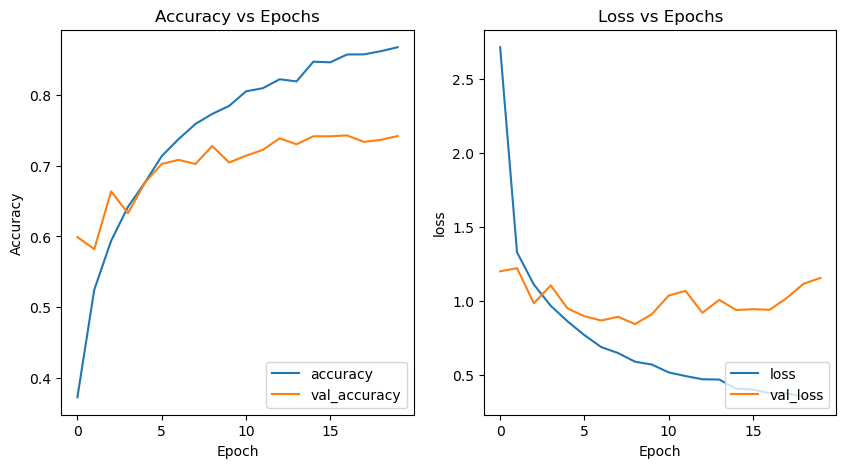

In [ ]:

# Define the number of classes
num_classes = 12

# Load the pre-trained VGG16 model
InceptionV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze all the layers in the base model
for layer in InceptionV3_model.layers:
    layer.trainable = False

# Add new classification layers on top of the frozen layers
x = Flatten()(InceptionV3_model.output)
x = Dense(512, activation='relu',kernel_initializer = 'glorot_uniform')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the new model
model_3 = Model(inputs=InceptionV3_model.input, outputs=predictions)

# Compile the model
model_3.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Print the model summary
# model_3.summary()

start3 = datetime.now() 
results = model_3.fit(X_train_aug ,Y_train_aug , batch_size=8,validation_split=0.2, epochs=20,shuffle=True)
stop3 = datetime.now()
execution_time = stop3-start3
print("\nInceptionV3 execution time is: ", execution_time)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Accuracy vs Epochs')
plt.plot(results.history['accuracy'], label='accuracy')
plt.plot(results.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2,)
plt.title('Loss vs Epochs')
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

plt.show()

In [ ]:
model_3.save('E:/Q/Trained_models/With augmentation/inceptionv3-aug-5epochs.hdf5')

## Reason for using the pre-processing steps

##### Channel A has maximum information , use this to mask the original image to remove background 

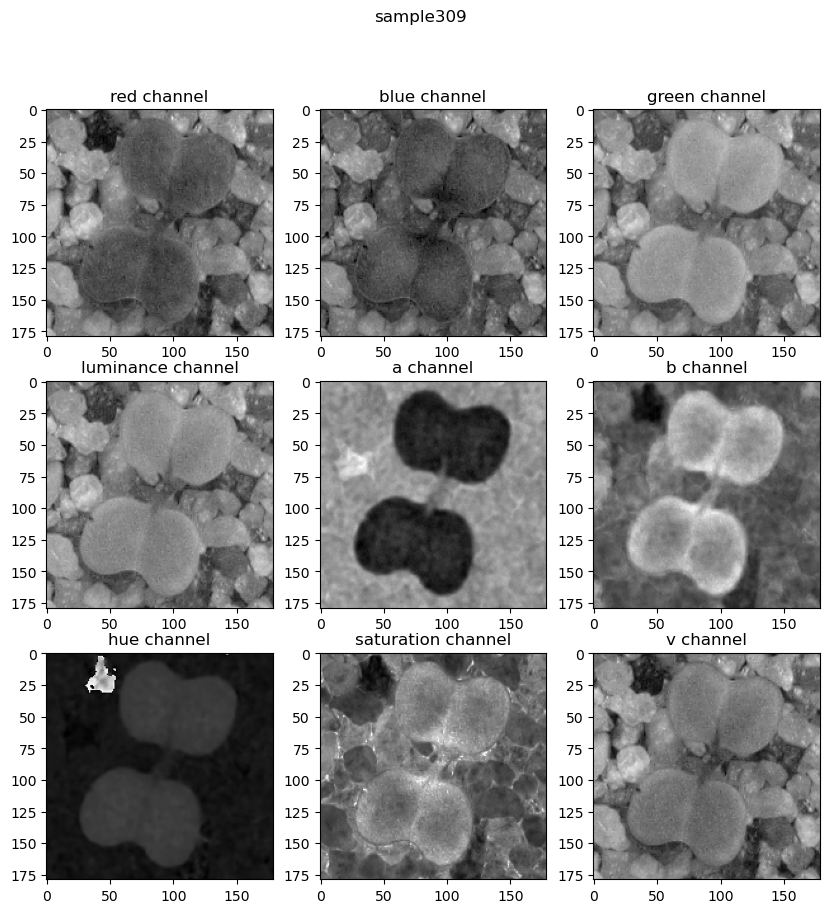

In [ ]:
#plotting each channel individually to determine which channel has max information

for i in random.sample(range(len(output['x_train_path'])),1):
    img = cv2.imread(output['x_train_path'][i],1)
    b,g,r = cv2.split(img)
    lab_img = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
    l,a,bl = cv2.split(lab_img)
    hsv_img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv_img)
    
    plt.figure(figsize=(10,10))
    plt.subplot(3,3,1)
    plt.suptitle('sample'+str(i))
    plt.title('red channel')
    plt.imshow(r,cmap='gray')
    
    plt.subplot(3,3,2)
    plt.title('blue channel')
    plt.imshow(b,cmap='gray')
    
    plt.subplot(3,3,3)
    plt.title('green channel')
    plt.imshow(g,cmap='gray')
    
    plt.subplot(3,3,4)
    plt.title('luminance channel')
    plt.imshow(l,cmap='gray')
    
    plt.subplot(3,3,5)
    plt.title('a channel')
    plt.imshow(a,cmap='gray')
    
    plt.subplot(3,3,6)
    plt.title('b channel')
    plt.imshow(bl,cmap='gray')
    
    plt.subplot(3,3,7)
    plt.title('hue channel')
    plt.imshow(h,cmap='gray')
    
    plt.subplot(3,3,8)
    plt.title('saturation channel')
    plt.imshow(s,cmap='gray')
    
    plt.subplot(3,3,9)
    plt.title('v channel')
    plt.imshow(v,cmap='gray')

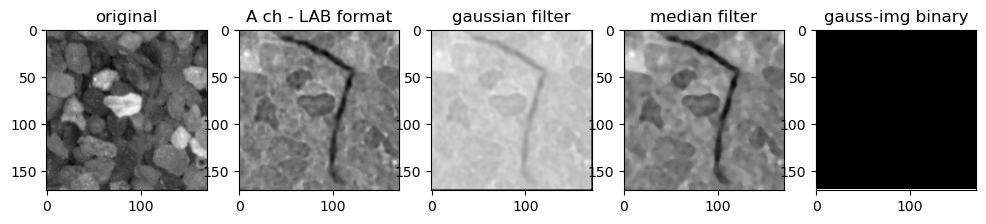

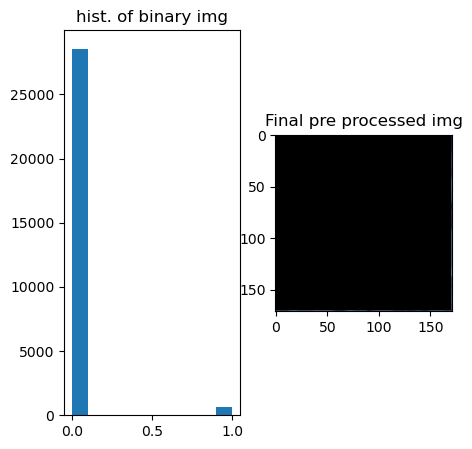

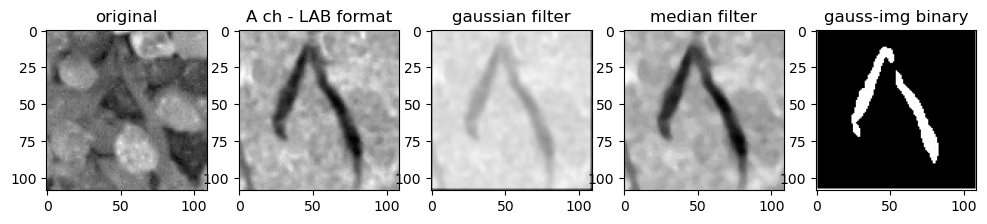

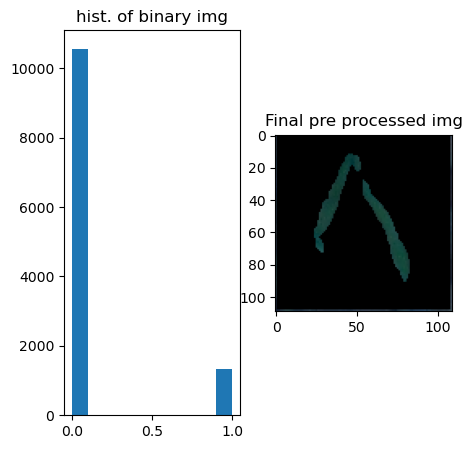

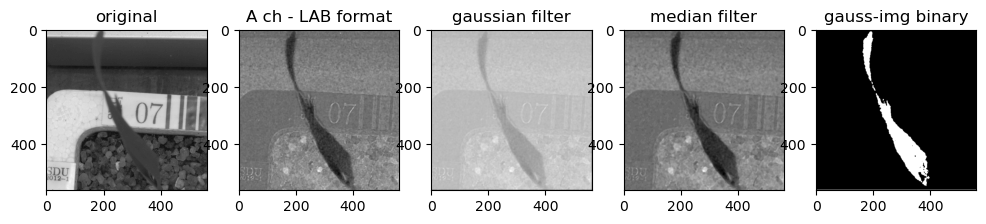

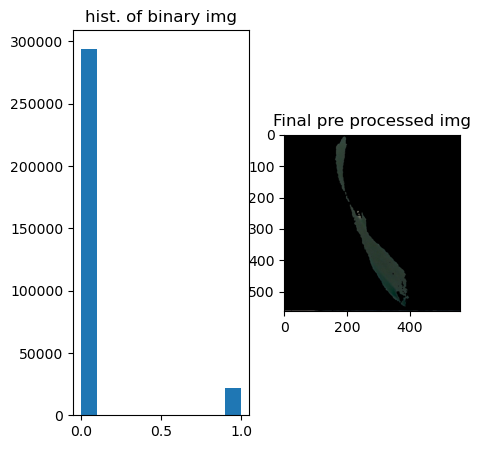

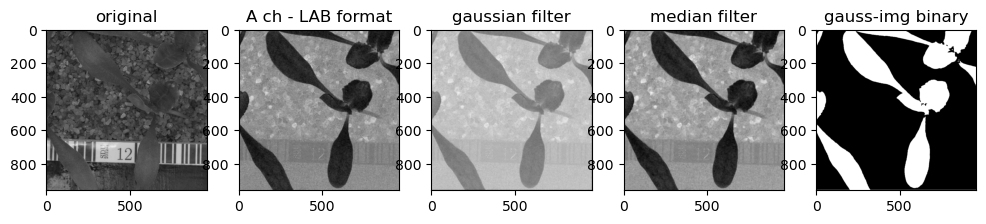

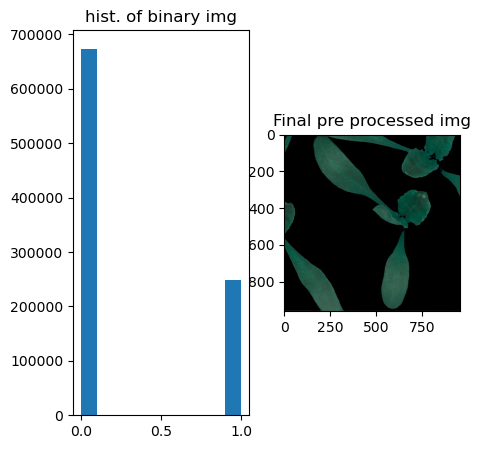

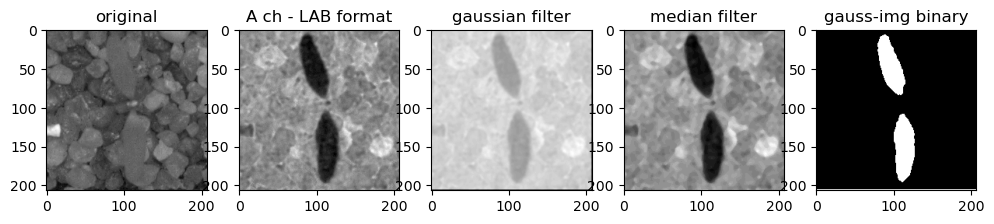

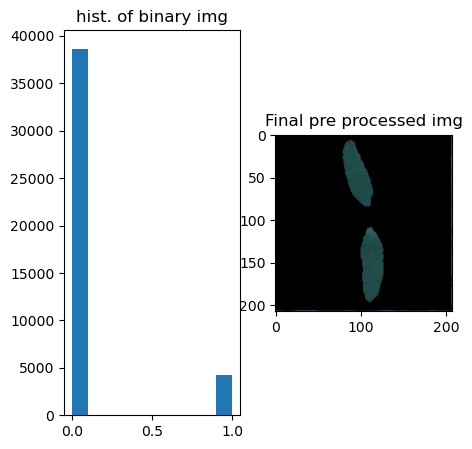

In [ ]:
#Pre-processing data


for i in random.sample(range(len(output['x_train_path'])),5):
    
    #reading the image
    img = cv2.imread(output['x_train_path'][i],1)
    
    #cvt bgr to lab
    lab_img = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
    
    #splitting channels to take channel a
    l,a,b = cv2.split(lab_img)
    
    #Checking which blurring technique is better
    gauss_img = cv2.GaussianBlur(a,(3,3),0,borderType = cv2.BORDER_CONSTANT)
    median_img = cv2.medianBlur(a,5)
    
    #Generating a mask to eliminate background
    thresh = threshold_multiotsu(gauss_img,classes=2)
    thresh_img = np.digitize(gauss_img, bins=thresh)*-1 + 1

    plt.figure(figsize=(12,12))
    
    plt.subplot(1,5,1)
    plt.title('original')
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY),cmap='gray')
    
    plt.subplot(1,5,2)
    plt.title('A ch - LAB format')
    plt.imshow(a,cmap='gray')
    
    plt.subplot(1,5,3)
    plt.title('gaussian filter')
    plt.imshow(gauss_img,cmap='gray')
    
    plt.subplot(1,5,4)
    plt.title('median filter')
    plt.imshow(median_img,cmap='gray')
    
    plt.subplot(1,5,5)
    plt.title('gauss-img binary')
    plt.imshow(thresh_img,cmap='gray')
    
    plt.figure(figsize=(5,5))
    
    plt.subplot(1,2,1)
    plt.title('hist. of binary img')
    plt.hist(thresh_img.flat)
    
    #eliminating background using binary mask
    img[:,:,0] = img[:,:,0]*thresh_img
    img[:,:,1] = img[:,:,1]*thresh_img
    img[:,:,2] = img[:,:,2]*thresh_img
    plt.subplot(1,2,2)
    plt.title('Final pre processed img')
    plt.imshow(img)